# Data Science PI7, Part 1

### 1. SQL Database Analysis

To assess the available values in our database ("cycling_big.db"), we will have to explore our database.
We will import the necessary modules and then make a query to our database by calling //the names of the tables and their column values//

Note that these operations are better handled by data handling and manipulation modules, like Pandas, which will be used later on.

In [99]:
import sqlite3 as lite
import pandas as pd
import seaborn as sns

In [98]:
conn = lite.connect('cycling_big.db')
cur = conn.cursor()

cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()

print("The following tables are present in our database")
for row in tables:
    print(row)

# We will be closing the database connection at the end of each code cell.
# By doing this we can make sure that queries dont interact with unwanted code cells.
conn.close()

The following tables are present in our database
('riders',)
('race_results',)
('sqlite_sequence',)


Note that the tables 'riders' and 'race_results' are present in the database. 
With this information, a query can be made to print out the first ten rows from our tables.

In [97]:
conn = lite.connect('cycling_big.db')
cur = conn.cursor()

conn = lite.connect('cycling_big.db')

# Execute a query to select all entries and put the labels in an arrary of description values

cur.execute('SELECT * FROM race_results')

columns_race = [description[0] for description in cur.description]

print("Columns for race_results:", columns_race)

cur.execute('SELECT * FROM riders')

columns_rider = [description[0] for description in cur.description]

print("Columns for riders:", columns_rider)

conn.close()

Columns for race_results: ['id', 'Rnk', 'GC', 'Timelag', 'BiB', 'Rider', 'Age', 'Team', 'UCI', 'Pnt', 'Time', 'Circuit', 'Race_Name', 'Stage_Name', 'Date', 'Stage_Type', 'Start', 'Finish', 'Race_ID', 'Stage_Number', 'Length', 'Category', 'Race_url', 'Stage_url', 'rider_id']
Columns for riders: ['rider_id', 'fullname', 'team', 'birthdate', 'country', 'height', 'weight', 'rider_url', 'pps', 'rdr']


#### Evaluating empty values quickly
Now let's quickly identify the amount of empty cells for race results. 
This will not give a full scope of missing or incorrect data, but this will offer us a quick overview of the columns that are missing entries.
Ofcourse, entry values like 'Date' can be expected to be unstandardized, or a value can be entered as 'null', but will still count as a value, so using SQL queries will not be the most accurate to determine missing or unstandardized data.

In [96]:
conn = lite.connect('cycling_big.db')
cur = conn.cursor()

cur.execute("PRAGMA table_info(race_results);") # Quick and dirty PRAGMA statement to return info on a column
columns = cur.fetchall()

# Building an SQL query to loop through all the columns to count nulls
null_count = "SELECT "

# Add each column's NULL count
null_count += ", ".join([f"SUM(CASE WHEN {column[1]} IS NULL THEN 1 ELSE 0 END) AS {column[1]}_null" for column in columns])

null_count += " FROM race_results;"

# Execute the query
cur.execute(null_count)

# Fetch the result
null_counts = cur.fetchone()

print("\nMissing Values Count for Each Column:")
print("-" * 50)
print(f"{'Column Name':<30} {'Missing Values'}")
print("-" * 50)

# Looping through the columns and applying formatting
for i, column in enumerate(columns):
    column_name = column[1]  # Column name is the second element in the tuple
    missing_values = null_counts[i]
    print(f"{column_name:<30} {missing_values:>15}")

print("-" * 50)

conn.close()


Missing Values Count for Each Column:
--------------------------------------------------
Column Name                    Missing Values
--------------------------------------------------
id                                           0
Rnk                                          0
GC                                       30420
Timelag                                  30420
BiB                                          0
Rider                                        0
Age                                          0
Team                                        29
UCI                                     214074
Pnt                                     194158
Time                                         0
Circuit                                      0
Race_Name                                    0
Stage_Name                               25241
Date                                         0
Stage_Type                                   0
Start                                        0
Finish        

### 2. Database Extraction and Deserialization

Below is a code sample for extracting data from a SQLite database. Using the built in 'sqlite' module for python, we can open a connection by calling the 'connect()' function that points to a "*.db" file. The returned connection object, named 'conn', represents the connection to the on-disk database. This essentially creates an interface for python to interact with the SQLite database. Using the 'Pandas' module, we can put this deserialized data from the database into a dataframe. A dataframe preserves the rows and columns from the relevant database. By using this data frame, the data from the database can be used for data handling, manipulation and further analysis.

In [114]:
# As shown in the above cells, a connection to the ".db" file can be established by 
conn = lite.connect("cycling_big.db")

table_names = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn) # Sqlite master is a system table that holds information like table names 
df = pd.read_sql(f"SELECT * FROM {table_names['name'][0]}", conn) # Access the first tables name from the table_names dataframe

conn.close()

df.head()

,rider_id,fullname,team,birthdate,country,height,weight,rider_url,pps,rdr
0,5e4c220d0657face20e49719b725a001,BARDET Romain,Team DSM,1990-11-09,France,1.84,65.0,https://www.procyclingstats.com/rider/romain-b...,"{'One day races': '2620', 'GC': '5138', 'Time ...","{'PCS Ranking': '43', 'UCI World Ranking': '52..."
1,995d110d3b2e05830409874b401a3218,DUMOULIN Samuel,noteam,1980-08-20,France,1.59,57.0,https://www.procyclingstats.com/rider/samuel-d...,"{'One day races': '3681', 'GC': '1277', 'Time ...",{'Specials | All Time Ranking': '365'}
2,21b52056733e39f06885dfb9d18bc77a,GALLOPIN Tony,AG2R Citroën Team,1988-05-24,France,1.80,69.0,https://www.procyclingstats.com/rider/tony-gal...,"{'One day races': '2864', 'GC': '2268', 'Time ...","{'PCS Ranking': '511', 'UCI World Ranking': '9..."
3,3fe13c77eb187357fa58c810a7aa7083,NAESEN Oliver,AG2R Citroën Team,1990-09-16,Belgium,1.84,72.0,https://www.procyclingstats.com/rider/oliver-n...,"{'One day races': '3619', 'GC': '1157', 'Time ...","{'PCS Ranking': '203', 'UCI World Ranking': '1..."
4,ae00cdf6b464b193c1a34e08fe1eded7,FRANK Mathias,noteam,1986-12-09,Switzerland,1.76,64.0,https://www.procyclingstats.com/rider/mathias-...,"{'One day races': '702', 'GC': '2803', 'Time t...","{'PCS Ranking': '755', 'UCI World Ranking': '9..."


### 3. Exploratory Data Analysis

In [130]:
conn = lite.connect('cycling_big.db')

riders_df = pd.read_sql_query('SELECT * FROM riders;', conn)
races_df = pd.read_sql_query('SELECT * FROM race_results', conn)

riders_df.describe(include='all')

conn.close()

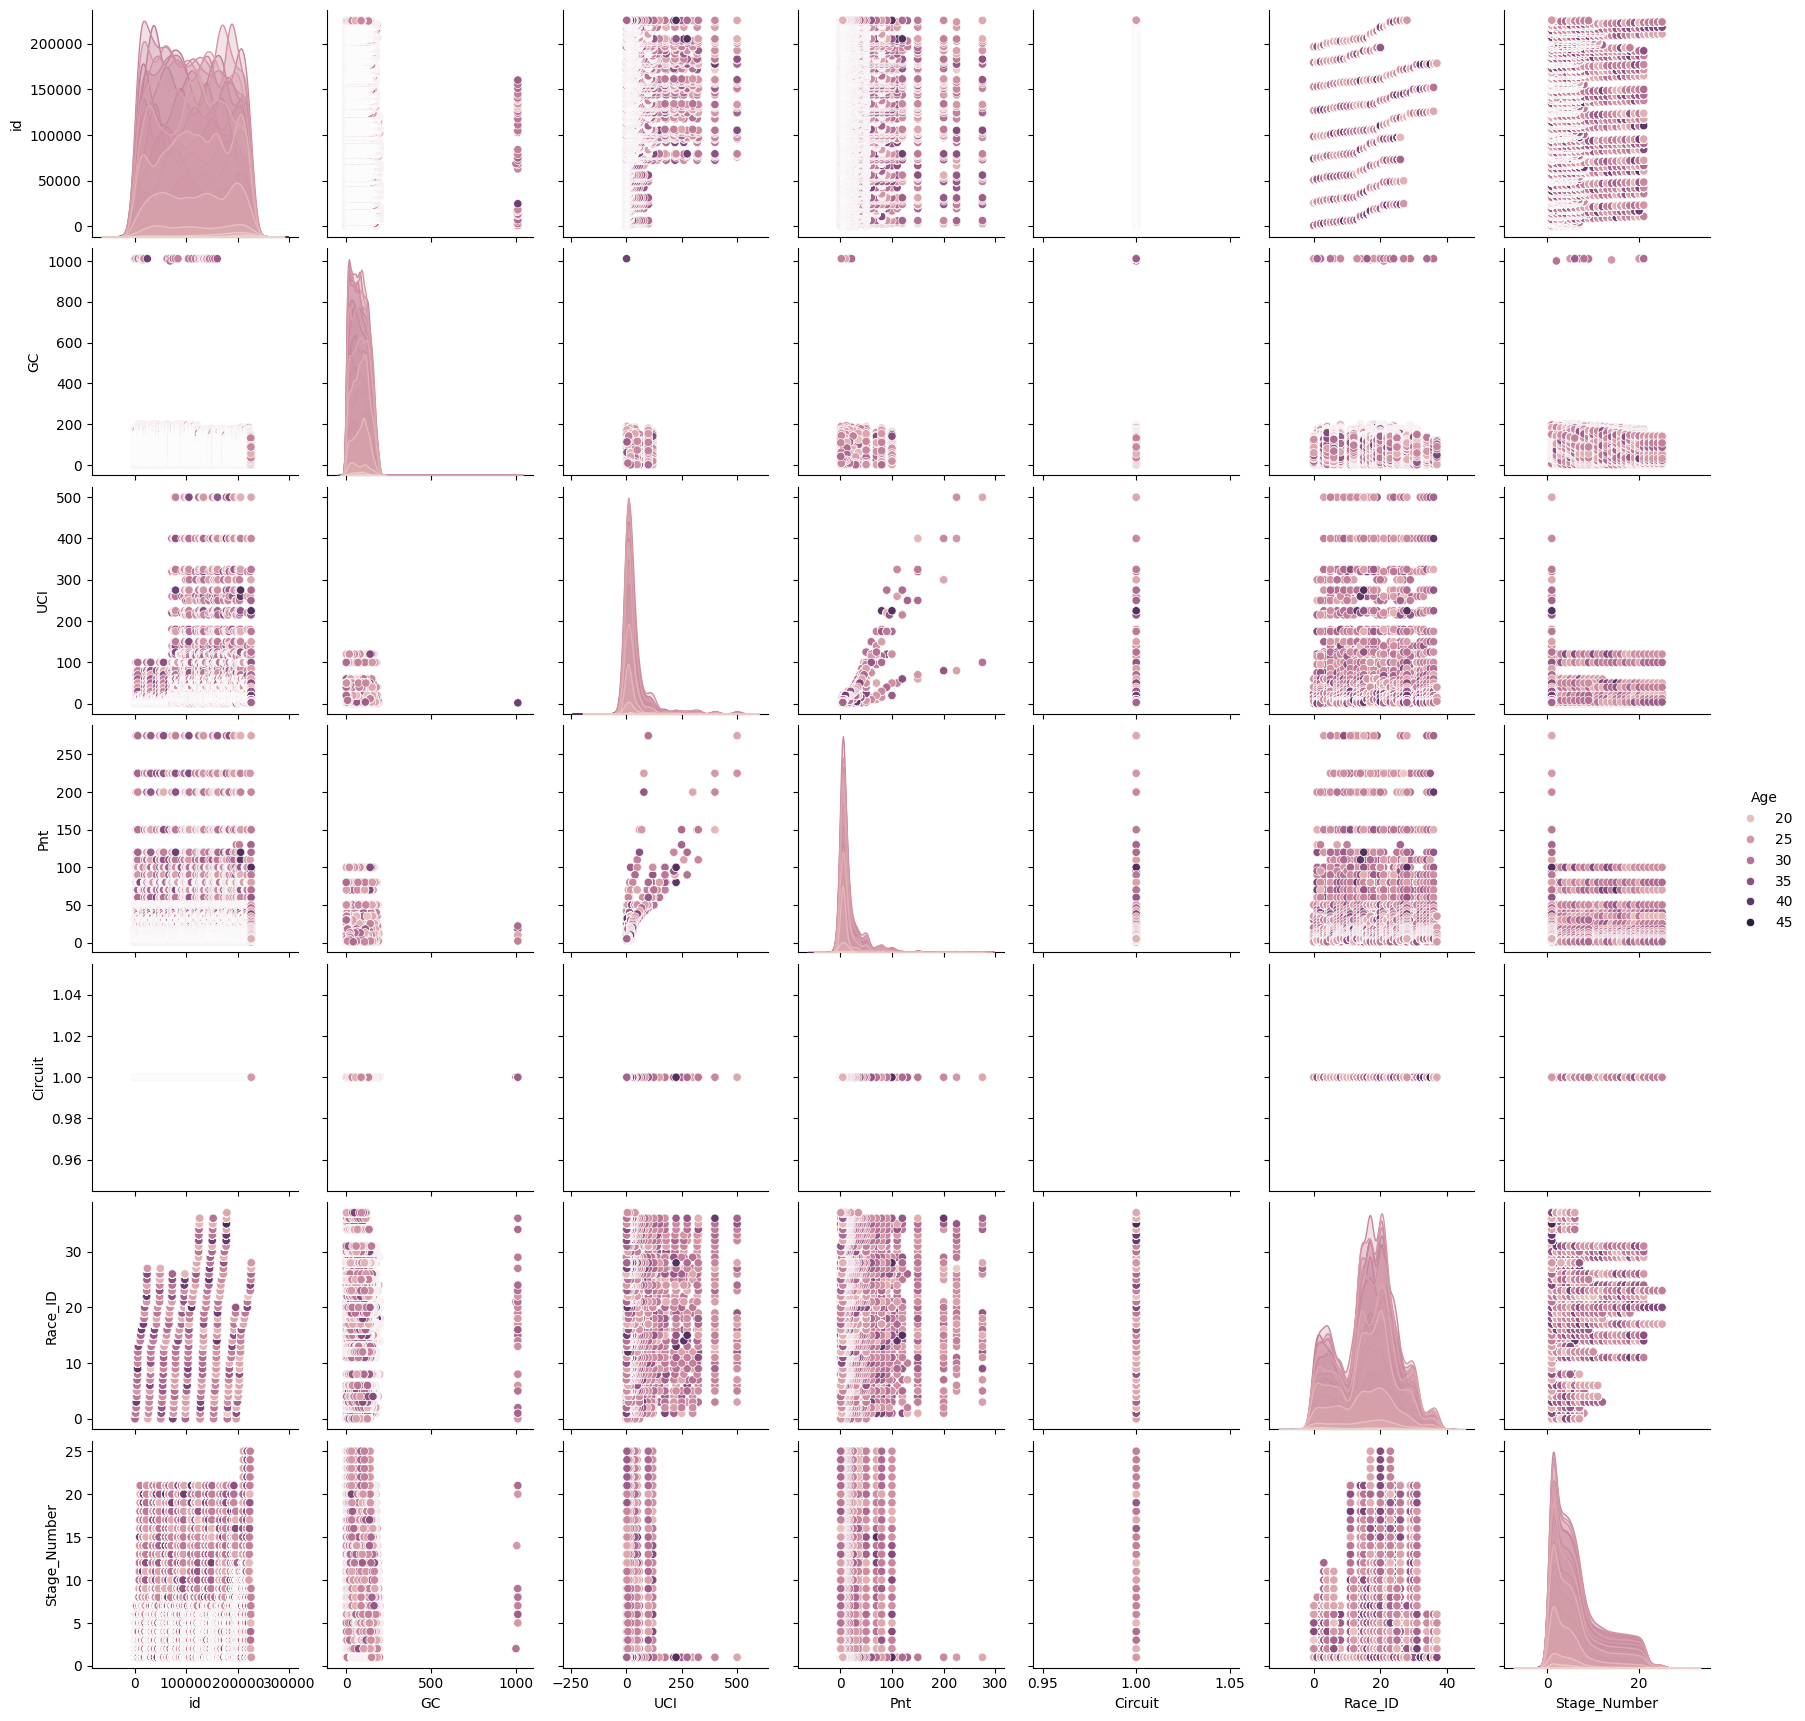

In [125]:
sns.pairplot(races_df, hue='Age')

In [129]:
sns.heatmap(races_df.corr())

ValueError: could not convert string to float: 'DNS'